In [1]:
import os
from sklearn import preprocessing
import statsmodels.api as sm
import missingpy
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
folder="D:\\smarcitiesdata"
list_of_database=os.listdir(folder)

## Load the databse

In [3]:
dataframe=pd.read_csv(folder+"\\"+list_of_database[3])
dataframe.set_index('tempo',inplace=True)
dataframe.index=pd.to_datetime(dataframe.index)

In [4]:
dataframe['week_day']=dataframe.index.weekday
dataframe['hour']=dataframe.index.hour
temporal_variables=['week_day','hour']

## create list of covariates

In [5]:
passages_variables=pd.read_csv(folder+"\\"+list_of_database[4])
passages_variables=list(passages_variables['passages_variables'])
passages_variables_smoothed=pd.read_csv(folder+"\\"+list_of_database[5])
passages_variables_smoothed=list(passages_variables_smoothed['passages_variables_smoothed'])
weather_variables=pd.read_csv(folder+"\\"+list_of_database[8])
weather_variables=list(weather_variables['weather_variables'])
weather_variables_smoothed=pd.read_csv(folder+"\\"+list_of_database[9])
weather_variables_smoothed=list(weather_variables_smoothed['weather_variables_smoothed'])
covariates=passages_variables+passages_variables_smoothed+weather_variables+weather_variables_smoothed+temporal_variables
print(covariates)

['CARS_FUEL_CLEAN', 'CARS_FUEL_NO_CLEAN', 'CARS_GREEN', 'VEHICLES_NA', 'VEHICLES_OTHER_CLEAN', 'VEHICLES_OTHER_GREEN', 'VEHICLES_OTHER_NOTNA', 'VEHICLES_OTHER_NO_CLEAN', 'CARS_FUEL_CLEAN_SMOOTH', 'CARS_FUEL_NO_CLEAN_SMOOTH', 'CARS_GREEN_SMOOTH', 'VEHICLES_NA_SMOOTH', 'VEHICLES_OTHER_CLEAN_SMOOTH', 'VEHICLES_OTHER_GREEN_SMOOTH', 'VEHICLES_OTHER_NOTNA_SMOOTH', 'VEHICLES_OTHER_NO_CLEAN_SMOOTH', 'Atmospheric Pressure', 'Global Radiation', 'Net Radiation', 'Precipitation', 'Relative Humidity', 'Temperature', 'Wind Direction', 'Wind Speed', 'Atmospheric Pressure_SMOOTH', 'Global Radiation_SMOOTH', 'Net Radiation_SMOOTH', 'Precipitation_SMOOTH', 'Relative Humidity_SMOOTH', 'Temperature_SMOOTH', 'Wind Direction_SMOOTH', 'Wind Speed_SMOOTH', 'week_day', 'hour']


## Additional_feature enginnering

In [7]:
sunday_dummy=[]
for daynumb in dataframe.index.weekday:
    if daynumb==6:
        x=1
    else:
        x=0    
    sunday_dummy.append(x)

saturday_dummy=[]
for daynumb in dataframe.index.weekday:
    if daynumb==5:
        x=1
    else:
        x=0
    saturday_dummy.append(x)

dataframe['sunday_dummy']=sunday_dummy
dataframe['saturday_dummy']=saturday_dummy
covariates.append('sunday_dummy')
covariates.append('saturday_dummy')

# Create AIR-QUALITY-INDEX

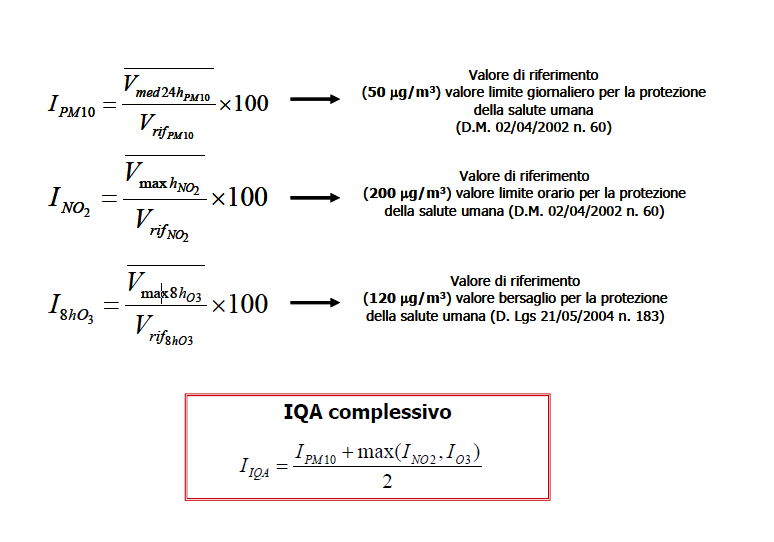

In [8]:
### http://www.provincia.torino.gov.it/europa/file-storage/download/pdf/europa_eventi/Pallavidino.pdf
Image(filename="C:\\Users\\gabri\\Desktop\\MADAS\\00airquality2019\\Presentations\\Air_Quality_Index_formula.png")

###

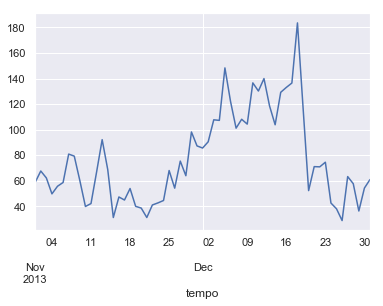

In [9]:
Daily_PM10=dataframe['PM10 (SM2005)'].resample('D').mean()
Daily_Nitrogen_Dioxide=dataframe['Nitrogene Dioxide'].resample('D').max()
EIGHTHours_Ozone=dataframe['Ozone'].rolling(8).mean().fillna(7.55)
Daily_Ozone=EIGHTHours_Ozone.resample('D').max()

rifPM_10=50
rifNO_2=200
rifhO3=120

Ipm_10=(Daily_PM10/rifPM_10)*100
Ino_2=(Daily_Nitrogen_Dioxide/rifNO_2)*100
Iho_3=(Daily_Ozone/rifhO3)*100

AIR_QUALITY_INDEX=(Ipm_10+np.maximum.reduce([Ino_2,Iho_3]))/2
pollution_list=list(dataframe.columns[0:10])
pollution_list.append('AIR_QUALITY_INDEX')
dataframe['AIR_QUALITY_INDEX']=AIR_QUALITY_INDEX.resample('H').pad()
## this is to fill 31st December
dataframe['AIR_QUALITY_INDEX'].fillna(61,inplace=True)
AIR_QUALITY_INDEX.plot();

## Description of the database

In [10]:
dataframe.describe()

,PM10 (SM2005),PM2.5,Ammonia,Benzene,BlackCarbon,Carbon Monoxide,Nitrogene Dioxide,Ozone,Ozono,Sulfur Dioxide,...,Precipitation_SMOOTH,Relative Humidity_SMOOTH,Temperature_SMOOTH,Wind Direction_SMOOTH,Wind Speed_SMOOTH,week_day,hour,sunday_dummy,saturday_dummy,AIR_QUALITY_INDEX
count,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,...,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000
mean,52.278689,45.163934,4.191386,2.658780,5.236845,1.663378,70.076192,9.410102,11.212169,6.297357,...,0.122589,78.987405,7.631119,196.514000,1.362534,3.016393,11.500000,0.147541,0.147541,77.074576
std,28.429167,26.185163,2.653705,2.336661,4.558069,0.693012,30.075042,9.669173,8.907323,3.691674,...,0.102186,8.917594,3.648731,31.216515,0.359865,2.029113,6.924552,0.354766,0.354766,35.107585
min,7.333333,6.500000,0.000000,0.100000,0.220000,0.550000,10.571429,3.000000,2.000000,0.000000,...,0.017310,62.012888,2.468439,138.515346,0.775166,0.000000,0.000000,0.000000,0.000000,28.895833
25%,29.666667,25.500000,2.339250,0.800000,1.653225,1.150000,49.875000,5.000000,5.500000,4.000000,...,0.034504,70.250695,4.365277,169.292748,1.010141,1.000000,5.750000,0.000000,0.000000,49.791667
50%,43.333333,36.000000,3.833000,1.733333,3.195150,1.500000,63.267857,6.000000,8.000000,5.000000,...,0.080583,80.846536,6.706930,194.931651,1.462304,3.000000,11.500000,0.000000,0.000000,67.656250
75%,71.000000,60.000000,4.988000,3.893750,8.109050,1.975000,84.875000,7.000000,13.000000,8.000000,...,0.190893,84.763765,11.211994,222.943507,1.608160,5.000000,17.250000,0.000000,0.000000,103.821429
max,130.333333,122.000000,17.200000,10.600000,19.490000,3.950000,212.666667,59.000000,53.500000,22.000000,...,0.437238,94.280620,13.349816,253.774590,2.276081,6.000000,23.000000,1.000000,1.000000,183.500000


# divide the dataframe into Xs and Ys

here we have to decide which is the variable we want to predict

In [11]:
print("please choose one of the following pollutant")
for x in pollution_list:
    print("{0} - {1}".format(pollution_list.index(x),x))
predicted_pollutant=int(input("plese enter a number between 0 and 10"))
print("OK...we will predict {0}".format(pollution_list[predicted_pollutant]))

please choose one of the following pollutant
0 - PM10 (SM2005)
1 - PM2.5
2 - Ammonia
3 - Benzene
4 - BlackCarbon
5 - Carbon Monoxide 
6 - Nitrogene Dioxide
7 - Ozone
8 - Ozono
9 - Sulfur Dioxide 
10 - AIR_QUALITY_INDEX


plese enter a number between 0 and 10 6


OK...we will predict Nitrogene Dioxide


In [12]:
X=dataframe.loc[:,covariates]
y=dataframe.loc[:,pollution_list[predicted_pollutant]]

#### do smoother matter for predictions ? 

In [42]:
# dataframe.index=pd.to_datetime(dataframe.index)
# X=dataframe.loc[:,passages_variables+weather_variables]
# y=dataframe.loc[:,pollution_list[predicted_pollutant]]

# FITTING A LINEAR MODEL

In [13]:
def train_test_timeseries(X,y,train_begin=0,train_end=500,test_size=168,matrix_mode='no',scale_x='no'):
    # test_size=168 ## (i.e. 1 week)
    if train_end+test_size>=X.shape[0]:
        test_size=X.shape[0]-train_end
    Xtrain=X.iloc[train_begin:train_end,:]
    ytrain=y.iloc[train_begin:train_end]
    Xtest=X.iloc[train_end:train_end+test_size,:]
    ytest=y.iloc[train_end:train_end+test_size]
    if matrix_mode=='yes':
        return np.matrix(Xtrain),np.matrix(ytrain),np.matrix(Xtest),np.matrix(ytest)  
    else:
        if scale_x=='yes':
            return preprocessing.scale(Xtrain),ytrain,preprocessing.scale(Xtest),ytest
        else:
            Xtrain,ytrain,Xtest,ytest
            
def mse_test(y_test,y_correct):
        mse = (np.square(y_test - y_correct)).mean()
        return mse

def compare_prediction(y_test,y_correct):
    y_test.plot()
    correct_y_series=pd.Series(y_correct,name='Prediction')
    correct_y_series.index=y_test.index
    correct_y_series.plot()
    plt.legend()
    plt.suptitle('MSE test '+str(np.round(mse_test(y_test=y_test,y_correct=y_correct),3)))
    plt.tight_layout()

def compare_prediction_plot(y_test,y_correct):
    plot1=y_test.plot()
    correct_y_series=pd.Series(y_correct,name='Prediction')
    correct_y_series.index=y_test.index
    plot1=correct_y_series.plot()
    plot1.legend()
    plot1.set_title('MSE '+str(np.round(mse_test(y_test=y_test,y_correct=y_correct),3)))
    #plot1.tight_layout()
    return plot1

## Divide train and test

the division by time

In [14]:
X_train, y_train, X_test, y_test = train_test_timeseries(X=X,y=y,train_begin=0,train_end=1055,test_size=408,matrix_mode='no',scale_x="yes")

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  del sys.path[0]
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  del sys.path[0]


### division with sklearn

In [15]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)

n.b.  please note that we can have fairly good results by changing the value of alpha

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


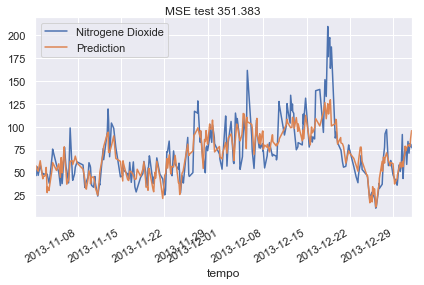

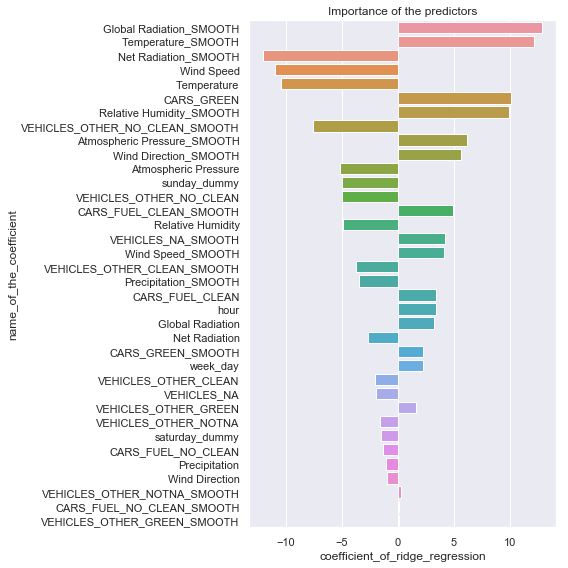

In [16]:
X_train_scaled=preprocessing.scale(X_train)
X_test_scaled=preprocessing.scale(X_test)
model = Ridge(alpha=7)
model.fit(X_train_scaled, y_train)
prediction_y=model.predict(X_test_scaled)    
compare_prediction(y_test=y_test,y_correct=prediction_y)
r2_score(y_test,prediction_y)
variable_importance=pd.DataFrame({'name_of_the_coefficient':covariates,'coefficient_of_ridge_regression':model.coef_,'absolute_coefficient':abs(model.coef_)})
variable_importance.sort_values('absolute_coefficient',ascending=False,inplace=True)
plt.figure(figsize=(8,8))
plt.title('Importance of the predictors')
barplot_importance=sns.barplot(variable_importance['coefficient_of_ridge_regression'],variable_importance['name_of_the_coefficient'],orient="h")
plt.tight_layout()

compare results when changing alpha

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


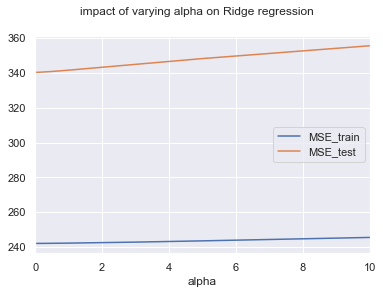

In [17]:
## please note this might cause overfitting
X_train_scaled=preprocessing.scale(X_train)
X_test_scaled=preprocessing.scale(X_test)
mse_train_results=[]
mse_test_results=[]
alpha_list=[0.001,0.005,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,3,5,10]
for alpha_ridge in alpha_list:
    model=Ridge(alpha=alpha_ridge)
    model.fit(X_train_scaled,y_train)
    mse_train_results.append(mse_test(model.predict(X_train_scaled),y_train))
    mse_test_results.append(mse_test(model.predict(X_test_scaled),y_test))

result=pd.DataFrame({'MSE_train':mse_train_results,'MSE_test':mse_test_results},index=alpha_list)
result.plot()
plt.suptitle('impact of varying alpha on Ridge regression')
plt.xlabel('alpha');

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


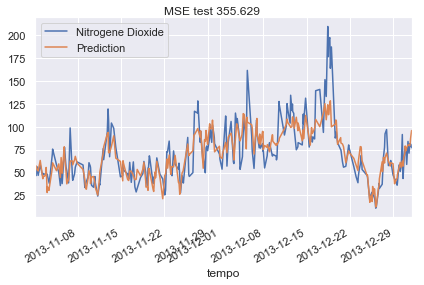

In [18]:
## alternativel we can use RIDGE CV
X_train_scaled=preprocessing.scale(X_train)
X_test_scaled=preprocessing.scale(X_test)
model.fit(X_train_scaled, y_train)
prediction_y=model.predict(X_test_scaled)    
compare_prediction(y_test=y_test,y_correct=prediction_y)

## Neural Network

ADD A RECURRENT LAYER
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470  
to bring memory

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1850      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 7,051
Trainable params: 7,051
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
R-squared equal to  0.6914453424699756


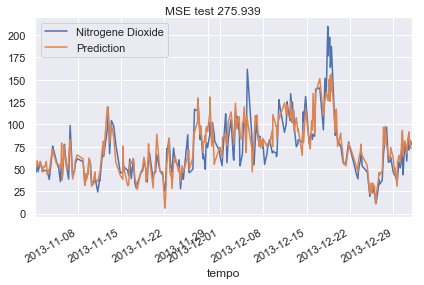

In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=500)

def build_model():
    model = keras.Sequential([layers.Dense(50, activation='linear', input_shape=[X_train.shape[1]]),layers.Dense(100, activation=tf.nn.relu),layers.Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=2000)

model=build_model()
model.summary()
EPOCHS = 2000
history = model.fit(X_train, y_train,epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[early_stop])
y_predictions = model.predict(X_test).flatten()
compare_prediction(y_test,y_predictions)
print('R-squared equal to ',r2_score(y_test,prediction_y))

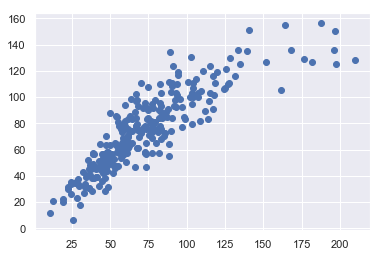

In [23]:
plt.scatter(y_test,y_predictions);

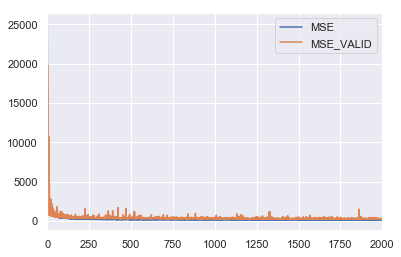

In [21]:
Mean_Squared_Error=history.history['mean_squared_error']
Mean_Squared_Error_validation=history.history['val_mean_squared_error']
pd.DataFrame({'MSE':Mean_Squared_Error,'MSE_VALID':Mean_Squared_Error_validation}).plot()
#plt.ylim(0,2)
#plt.xlim(0,)

## log-log visualization

Text(0.5, 1.0, 'Number of Epochs')

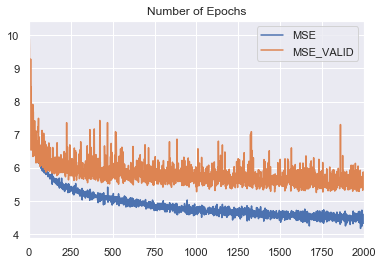

In [22]:
Mean_Squared_Error=np.log(history.history['mean_squared_error'])
Mean_Squared_Error_validation=np.log(history.history['val_mean_squared_error'])
pd.DataFrame({'MSE':Mean_Squared_Error,'MSE_VALID':Mean_Squared_Error_validation}).plot();
plt.title('Number of Epochs')
#plt.ylim(0,2)
#plt.xlim(0,)

####
- linear model
- ridge
- SVM
- Neural network

### some correlation matrixes of the pollutant with heatmap

AQI index predicted with two approaches...
- in one we first product the pollutant and after we compute the corresponding AQI ...and then the corresponding class.
- directly predict  the AQI absolut
- eventually predict AQI class (classification tasks)

results normalized mean squared error or simply mean squared error

In [ ]:
# X_train, X_test,y_train,y_test